In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import wavfile

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import Lambda

from fastai.dataloader import DataLoader
from fastai.dataset import get_cv_idxs, split_by_idx, ArraysIndexDataset, ModelData
from fastai.metrics import accuracy
from fastai.model import fit, predict

from data_loading_utils import load_audio_files, read_file
from preprocessing_utils import load_features

In [211]:
PATH = Path('F:/freesound-audio-tagging')
TRAIN_PATH = PATH/'audio_train'
TEST_PATH = PATH/'audio_test'

sample_rate = 44100
n_segments = 220  # approx 2.5 seconds
n_features = 40
n_fft = 1024

In [212]:
train = pd.read_csv(PATH/'train.csv')

labels = sorted(train.label.unique())
label_idx = {label:i for i, label in enumerate(labels)}

In [213]:
import pickle

In [214]:
x = load_features(TRAIN_PATH, filenames=train.fname, feature_name='log_mel_spec', n_fft=n_fft, n_features=n_features)

Loading audio files...


Computing log_mel_spec features..


Saving data..
Loaded features for 9473 files


In [7]:
# x = pickle.load(open('tmp/audio_train_log_mel_spec_80_1024_512_44100_raw.p', 'rb'))
# x = load_features(TRAIN_PATH, filenames=train.fname, feature_name='log_mel_spec', n_fft=n_fft, n_features=n_features)

In [215]:
y = train.label.apply(lambda l: label_idx[l]).values
len(x), len(y)

(9473, 9473)

In [216]:
x[0].shape, y.shape

((40, 1206), (9473,))

In [246]:
test = pd.read_csv(PATH/'sample_submission.csv')
test_x = load_features(TEST_PATH, filenames=test.fname, feature_name='log_mel_spec', n_fft=n_fft, n_features=n_features)
test_y = np.zeros(len(test_x))
len(test_x), len(test_y)

Loading audio files...


Computing log_mel_spec features..


Empty File
Empty File
Empty File
Saving data..
Loaded features for 9400 files


(9400, 9400)

In [261]:
# from blake
def get_trn_val_split(x, y, val_pct=0.15):
    val_idxs = get_cv_idxs(len(x), val_pct=val_pct)
    if isinstance(x, list):
        return [([arr[i] for i in val_idxs], [arr[i] for i in range(len(arr)) if i not in val_idxs]) for arr in [x,y]]
    else:
        return split_by_idx(val_idxs, x, y)

In [262]:
((val_x, trn_x), (val_y, trn_y)) = get_trn_val_split(x, y, 0.15)

len(trn_x), len(trn_y), len(val_x), len(val_y)

(8053, 8053, 1420, 1420)

In [249]:
def random_subset2d(x, n):    
    if x.shape[0] > n:
        offset = np.random.randint(x.shape[0] - n)
        return x[offset:offset+n]
    elif x.shape[0] < n:
        pad_total = n - x.shape[0]
        pad_start = np.random.randint(pad_total)
        pad_end = pad_total - pad_start
        return np.pad(x, ((pad_start, pad_end), (0, 0)), mode='wrap') # zeros
    else:
        return x

In [250]:
class RandomOffsetArraysIndexDataset(ArraysIndexDataset):
    def __init__(self, x, y, n_segments, transform=None):
        self.n_segments = n_segments
        assert(len(x)==len(y))
        super().__init__(x, y, transform)
    
    def get_x(self, i):
        data = self.x[i].T
        return random_subset2d(data, self.n_segments)
    
    def get_sz(self):
        return self.n_segments

In [251]:
# Takes the middle two seconds of the audio file to run the model on
class AudioArraysIndexDataset(ArraysIndexDataset):
    def __init__(self, x, y, n_segments, transform=None):
        self.n_segments = n_segments
        assert(len(x)==len(y))
        super().__init__(x, y, transform)
    
    def get_x(self, i):
        data = self.x[i].T
        if data.shape[0] < self.n_segments:
            data = np.pad(data, ((0, self.n_segments-data.shape[0]), (0, 0)), 'constant')
        elif data.shape[0] > self.n_segments:
            offset = (data.shape[0] - self.n_segments) // 2
            data = data[offset:offset+self.n_segments]
        return data
    
    def get_sz(self):
        return self.n_segments

In [252]:
def conv_block(n_in, n_out, dropout=0.2, kernel=7, maxpool=2):
    return nn.Sequential(
        nn.Conv2d(n_in, n_out, kernel_size=(kernel, kernel), padding=(3, 3), bias=False),
        nn.BatchNorm2d(n_out, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1, inplace=True),
        nn.MaxPool2d(maxpool),
        nn.Dropout(dropout, inplace=True)
    )

class Lambda(nn.Module):
    def __init__(self, lambd):
        super().__init__()
        self.lambd = lambd
    def forward(self, x):
        return self.lambd(x)

class AudioCNN_MFCC(nn.Module):
    def __init__(self, n_classes, n_segments, n_features):
        super().__init__()

        linear_input_ch = ((n_features//16) * (n_segments//16)) * 64
        
        self.layers = nn.Sequential(
            # Add in channel dimension
            Lambda(lambda x: x.view(x.shape[0], 1, x.shape[1], x.shape[2])),
            conv_block(1, 32, dropout=.1),
            conv_block(32, 32, dropout=.1),
            conv_block(32, 64),
            conv_block(64, 64),
            Lambda(lambda x: x.view(x.shape[0], -1)),
            nn.Linear(linear_input_ch, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, n_classes)
        )
        
    def forward(self, x):
        return self.layers(x)

In [266]:
 # ArraysIndexDataset expects np arrays
trn_y, val_y = np.array(trn_y), np.array(val_y)

trn_ds = RandomOffsetArraysIndexDataset(trn_x, trn_y, n_segments)
val_ds = RandomOffsetArraysIndexDataset(val_x, val_y, n_segments)
trn_dl = DataLoader(trn_ds, shuffle=True, batch_size=64)
val_dl = DataLoader(val_ds, shuffle=False, batch_size=64)
test_ds = AudioArraysIndexDataset(test_x, test_y, n_segments)
test_dl = DataLoader(test_ds, shuffle=False, batch_size=64)

In [267]:
x1, y1 = next(iter(trn_dl))
x1.size(), y1.size()

(torch.Size([64, 220, 40]), torch.Size([64]))

In [268]:
next(iter(test_dl))[0].shape

torch.Size([64, 220, 40])

In [286]:
model = AudioCNN_MFCC(len(labels), n_segments, n_features).cuda()
md = ModelData(PATH, trn_dl, val_dl, test_dl=test_dl)

In [287]:
from fastai.conv_learner import *

In [288]:
opt = partial(optim.Adam, betas=(0.8,0.99))
metrics = [accuracy]
loss = F.cross_entropy

In [289]:
learn = ConvLearner.from_model_data(model, md, crit=loss, metrics=metrics, opt_fn=opt)

In [306]:
learn.lr_find(1e-6, 1e-1)

epoch      trn_loss   val_loss   accuracy                   
    0      2.162644   855.063305 0.01831   


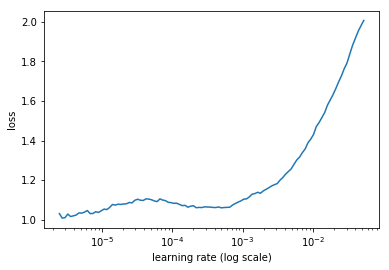

In [307]:
learn.sched.plot()

In [292]:
learn.fit(1e-3, 1, cycle_len=5, use_clr_beta=(5, 20, 0.95, 0.75))

epoch      trn_loss   val_loss   accuracy                   
    0      3.055078   3.685654   0.034507  
    1      2.382594   2.668481   0.28169                    
    2      1.941807   3.781081   0.219718                   
    3      1.684467   2.003433   0.447887                   
    4      1.481953   1.61237    0.56831                    


[array([1.61237]), 0.5683098590709794]

In [293]:
learn.save('conv2d_0-220-40-bs64.w')

In [294]:
learn.load('conv2d_0-220-40-bs64.w')

In [295]:
learn.fit(2e-4, 1, cycle_len=5, use_clr_beta=(5, 20, 0.95, 0.75))

epoch      trn_loss   val_loss   accuracy                   
    0      1.466312   1.843694   0.489437  
    1      1.439423   1.71458    0.541549                   
    2      1.401664   1.49125    0.600704                   
    3      1.318717   1.429005   0.616197                   
    4      1.275615   1.419164   0.627465                   


[array([1.41916]), 0.6274647887323944]

In [296]:
learn.save('conv2d_1-220-40-bs64.w')

In [309]:
learn.load('conv2d_1-220-40-bs64.w')

In [310]:
learn.fit(5e-5, 1, cycle_len=5, use_clr_beta=(5, 20, 0.95, 0.75))

epoch      trn_loss   val_loss   accuracy                   
    0      1.276321   1.403396   0.623239  
    1      1.247176   1.465834   0.60493                    
    2      1.26243    1.417542   0.611268                   
    3      1.239195   1.429752   0.607746                   
    4      1.235225   1.356215   0.630282                   


[array([1.35622]), 0.6302816901408451]

In [ ]:
learn.save('conv2d_2-220-40-bs64.w.w')

In [ ]:
learn.load('conv2d_2-220-40-bs64.w.w')

In [311]:
predictions = learn.predict(is_test=True)

In [312]:
top_3 = np.array(labels)[np.argsort(-predictions, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]

In [313]:
test.label = predicted_labels

In [314]:
test.to_csv('fixed_2d_conv_log_mel_spec.csv', index=False)